## Project 5 - Vehicle Detection and Tracking

##### Minming Zhao

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### Step1: Data Exploration
There are 8792 number of samples in cars set, 8968 number of samples in notcars set. 
We plot example car and not car image to have a general idea about the dataset. 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [2]:
cars = glob.glob('./data/vehicles/GTI_Far/*.png')
cars += glob.glob('./data/vehicles/GTI_MiddleClose/*.png')
cars += glob.glob('./data/vehicles/GTI_Left/*.png')
cars += glob.glob('./data/vehicles/GTI_Right/*.png')
cars += glob.glob('./data/vehicles/KITTI_extracted/*.png')

notcars = glob.glob('./data/non-vehicles/Extras/*.png')
notcars += glob.glob('./data/non-vehicles/GTI/*.png')

print('Number of samples in cars set: ', len(cars))
print('Number of samples in notcars set: ', len(notcars))

# Save the data for easy access
pickle_file = 'data_carsnotcars.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'cars': cars,
                'notcars': notcars,
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Number of samples in cars set:  8792
Number of samples in notcars set:  8968
Saving data to pickle file...
Data cached in pickle file.


In [3]:
## load data.p
data_file = 'data_carsnotcars.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars = data['cars']
notcars = data['notcars']


Sample image of car and sample image of not car

car image:  ./data/vehicles/GTI_Far/image0262.png ;
not car image:  ./data/non-vehicles/Extras/extra1270.png


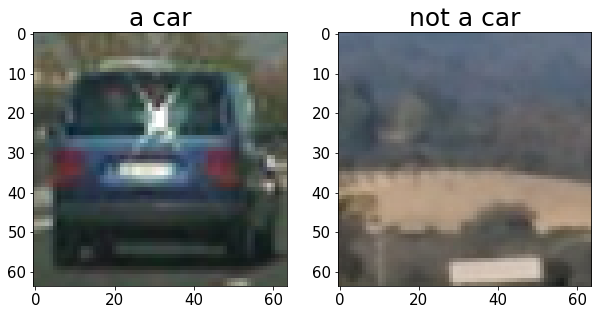

In [44]:
i=200
a_car = plt.imread(cars[i])
not_a_car = plt.imread(notcars[i])
print('car image: ',cars[i],';\nnot car image: ',notcars[i])

font_size=15
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(a_car)
ax1.set_title('a car', fontsize=25)
ax2.imshow(not_a_car)
ax2.set_title('not a car', fontsize=25)
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 
plt.show()

### Step2: Extract image features to identify car and not car content.  
I used HoG (Histogram of oriented gradients), spatial_features, color histogram to extract image features. 
- spatial feature (reduce the image size): 
`spatial_features = bin_spatial(feature_image, size=spatial_size)`
- color histogram feature (np.histogram on color image):
`hist_features = color_hist(feature_image, nbins=hist_bins)`
- HoG feature (get histogram of oriented gradient after converting image to certain color space onto every block and cells, hog is in `skimage.feature` package):
`features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=vis, feature_vector=feature_vec)`

I applied a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. One critical task is to investigate and find the best HoG parameter which leads to best testing accuracy. 

In [5]:
#%% HOG classify
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import sklearn.svm as svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib
from lesson_functions import *

# Load the training validation and test data
data_file = 'data_carsnotcars.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars = data['cars']
notcars = data['notcars']


In [6]:
def get_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(img_features)
    return features

### Parameter selection
In this project linear SVM is used and provided an acceptable testing accuracy. 
80% of dataset has been used a training set and 20% as testing set. We shuffle data before training to avoid algortihm remembering the ordering. I tried different combination of HoG settings as well color space for feature extraction. The different option testing accuracies are included below: 

| Option | Color Space | Spatial_size |Hist_bins|  Orientations | Pixels_per_cell | Cells_per_block | HOG channel | Time for Train | Time to Predict first 100 | Testing Accuracy |
|:------:|:-----------:|:------------:|:-------:|:-------------:|:---------------:|----------------:|------------:|---------------:|--------------------------:|-----------------:|
| 0   |  RGB   | (16,16) | 32 | 8 | 7 | 2 | All | 28.16s | 0.003s | 97.4% |
| 1   |  HSV   | (16,16) | 32 | 8 | 7 | 2 | All | 7.64s  | 0.003s | 98.7% |
| 2   |  HLS   | (16,16) | 32 | 9 | 8 | 2 | All | 10.5s  | 0.003s | 94.4% |
| 3   |  YCrCb | (32,32) | 32 | 9 | 7 | 2 | All | 8.29s  | 0.003s | 98.9% |
| 4   |  YCrCb | (32,32) | 16 | 8 | 7 | 2 | All | 8.39s  | 0.003s | 98.9% |
| 5   |  YCrCb | (32,32) | 32 | 8 | 7 | 2 | All | 21.4s  | 0.003s | 99.1% |
| 6   |  YCrCb | (16,16) | 32 | 8 | 8 | 2 | All | 15.3s  | 0.003s | 98.7% |
| 7   |  YCrCb | (16,16) | 32 | 8 | 7 | 2 | All | 18.6s  | 0.003s | 98.8% |
Hence we select option 5 which use ColorSpace of YCrCb and Spatial_size (32,32), 32 Hist bins, orient 8, Pixels_per_cell 7, Cell_per_block of 2, HOG channel All. 

In [7]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
orient = 8
pix_per_cell = 7
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

In [8]:
t=time.time()
cars_feature = get_features(cars,color_space, spatial_size,hist_bins, orient,
                            pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_feature = get_features(notcars,color_space, spatial_size,hist_bins, orient,
                            pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'seconds to extract HOG, spatial and color features')


87.78 seconds to extract HOG, spatial and color features


### Step3: Normalize features and use machine learning method (SVM in this task) to train dataset using optimized parameters for extracting features
I used StandScaler() to normalize extracted features.

In [9]:
X = np.vstack((cars_feature,notcars_feature)).astype(np.float64)
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))               
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_X_cars = scaled_X[:len(cars_feature)]
scaled_X_notcars = scaled_X[len(cars_feature):]

And we could see before and after normalization: 

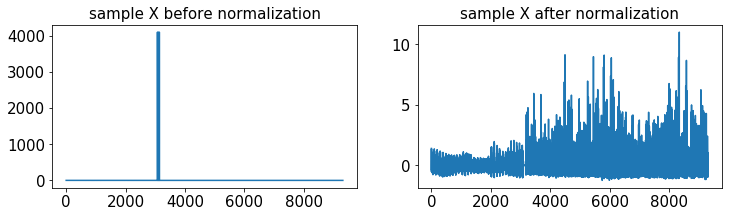

In [45]:
fig = plt.figure(figsize = (12,3))
plt.subplot(121)
plt.plot(X[0])
plt.title('sample X before normalization',fontsize = 15)
plt.subplot(122)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(scaled_X[0])
plt.title('sample X after normalization',fontsize = 15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.show()

In [10]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 8 orientations 7 pixels per cell and 2 cells per block
Feature vector length: 9312


In [11]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


8.04 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9879


In [12]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.]
For these 100 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00713 Seconds to predict 100 labels with SVC


Below we take a look at HoG features output. 

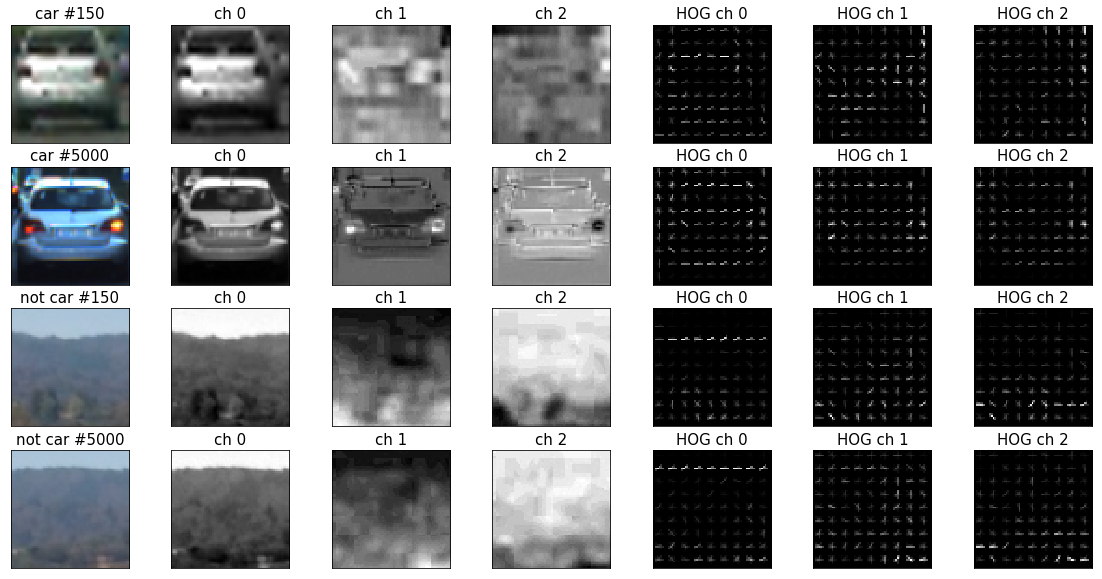

In [14]:
font_size=15
f, axarr = plt.subplots(4, 7,figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
#colorspace = cv2.COLOR_RGB2HLS
#colorspace=cv2.COLOR_RGB2HSV
colorspace=cv2.COLOR_RGB2YCrCb

i1,i2=150,5000

for ind,j in enumerate([i1,i2]):
    image = plt.imread(cars[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "car #{0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])    
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
        
for indn,j in enumerate([i1,i2]):
    ind=indn+2
    image = plt.imread(notcars[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "not car #{0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])        
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
              
plt.show()
#plt.savefig('./output_images/HOG_features_YCrCb.png')

### plot false positives/negatives
As the testing accuracy is not 100%, we will have false positive as well false negative classfication. We look into the fault ones to get an idea how they look like. Later we will apply heatmap method to filter them out. 

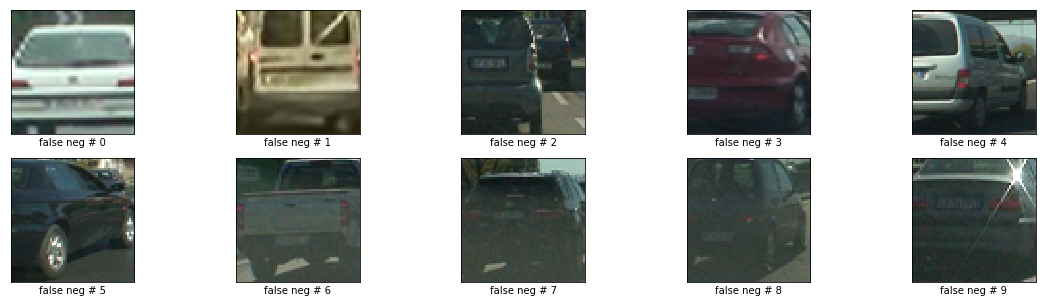

number of misclassified car images 27 out of  8792


In [16]:
font_size=15
preds = svc.predict(scaled_X_cars)
# misclassifieds = np.array(preds != y_test)
inds = np.where(preds != np.ones(len(scaled_X_cars)))
# inds = np.where(np.not_equal(preds,np.ones(len(cars_feature))))
inds = np.ravel(inds)
misclassifieds = [ cars[i] for i in inds]
    
fig, axes = plt.subplots(2,5,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false neg # {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     
    

plt.show()
print('number of misclassified car images',len(misclassifieds), 'out of ', len(scaled_X_cars))
# plt.savefig('./output_images/false_negatives.png')


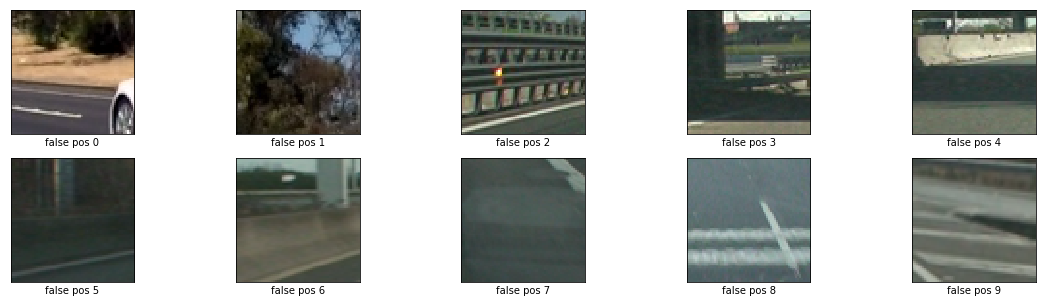

number of misclassified notcar images 16 out of  8968


In [17]:
fig, axes = plt.subplots(2,5,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
preds = svc.predict(scaled_X_notcars)
inds = np.where(preds != np.zeros(len(scaled_X_notcars)))
inds = np.ravel(inds)
misclassifieds = [ notcars[i] for i in inds]

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false pos {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     

plt.show()
print('number of misclassified notcar images',len(misclassifieds), 'out of ', len(scaled_X_notcars))
plt.savefig('./output_images/false_positives.png')

In [18]:
# Save the data for easy access
pickle_file = 'ProcessedData.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
print('Data cached in pickle file.')


pickle_file = 'ClassifierData.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.
Saving data to pickle file...
Data cached in pickle file.


### Step4: Build a sliding window technique to identify car/not car content from a large image 
We used 6 different sizes windows to detect car or not car content. X direction cover from leftmost to rightmost, while y direction covers from near front of driving car to the horizon. We use overlay of 75% as a default. We have smaller windows mainly at the horizon for smaller car images as they will appear far away. 

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

In [20]:
# Load the classifier and parameters
data_file = 'ClassifierData.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

images = sorted(glob.glob('test_images/*.jpg'))

In [21]:
def search_all_scales(image):
    
    hot_windows = []
    all_windows = []

    X_start_stop =[[None,None],[None,None],[None,None],[None,None],[None,None],[None,None]]
    w0,w1,w2,w3,w4,w5 = 240,200,160,120, 80, 60 # 240,180,120,70
    o0,o1,o2,o3,o4,o5 = 0.75,0.75,0.75,0.75, 0.75, 0.75
    XY_window = [(w0,w0),(w1,w1),(w2,w2),(w3,w3), (w4,w4), (w5,w5)]
    XY_overlap = [(o0,o0),(o1,o1),(o2,o2),(o3,o3), (o4,o4),(o5,o5)]
    yi0,yi1,yi2,yi3,yi4,yi5 = 380,380,390,395,400,405                
    Y_start_stop =[[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2],[yi4,yi4+w4/2],[yi5,yi5+w5/2]]    

    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

1.15 Seconds to search windows ...
(6,)


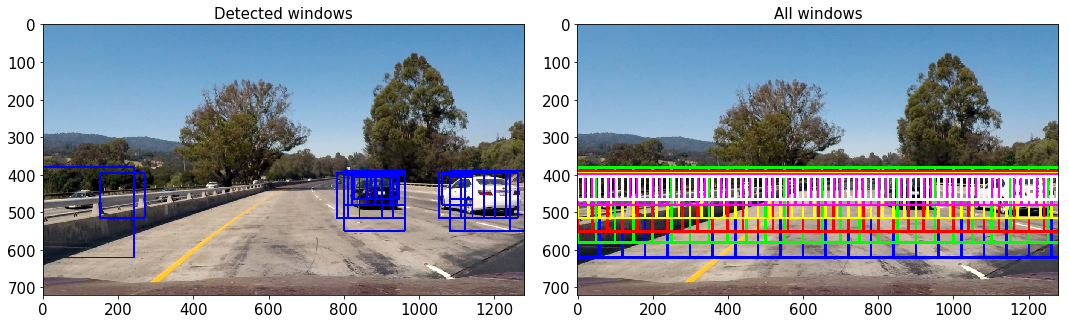

1.13 Seconds to search windows ...
(6,)


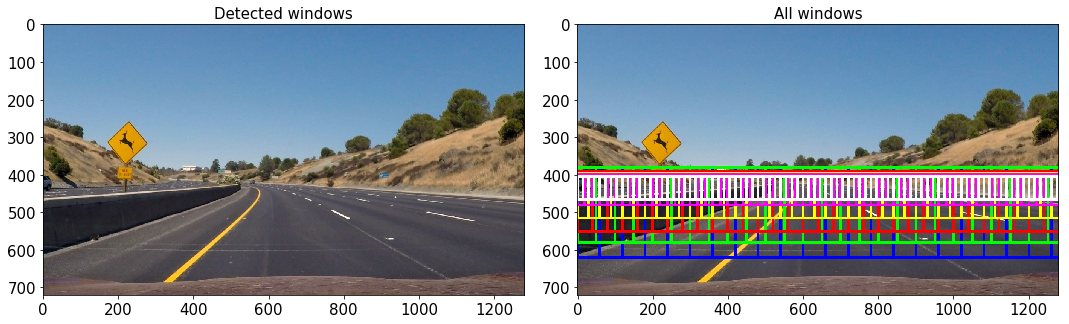

1.16 Seconds to search windows ...
(6,)


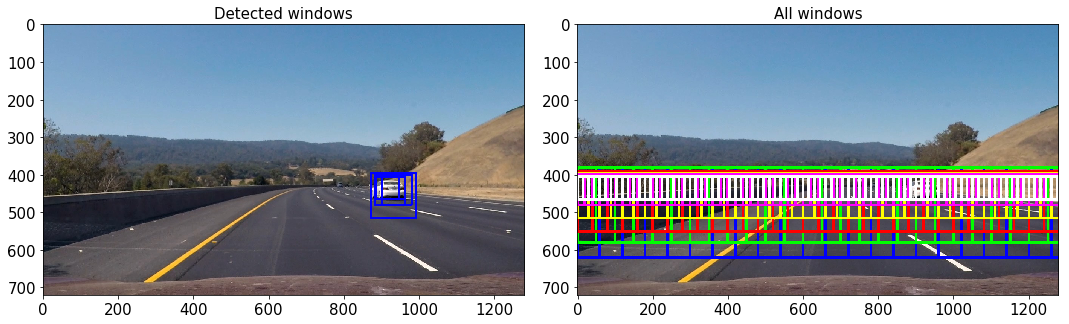

1.25 Seconds to search windows ...
(6,)


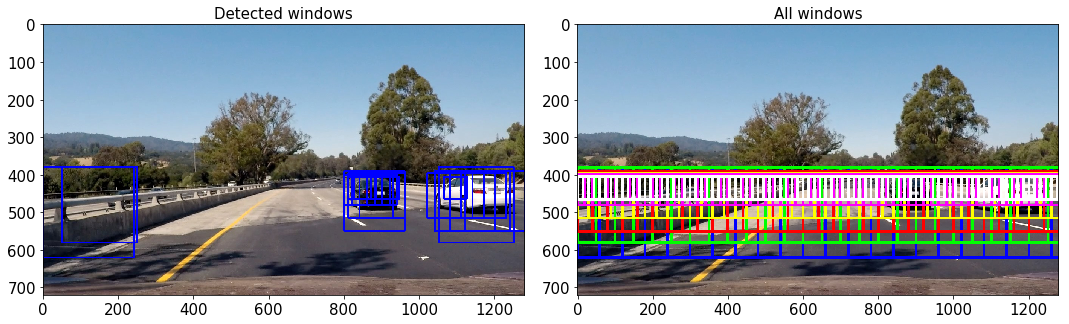

1.27 Seconds to search windows ...
(6,)


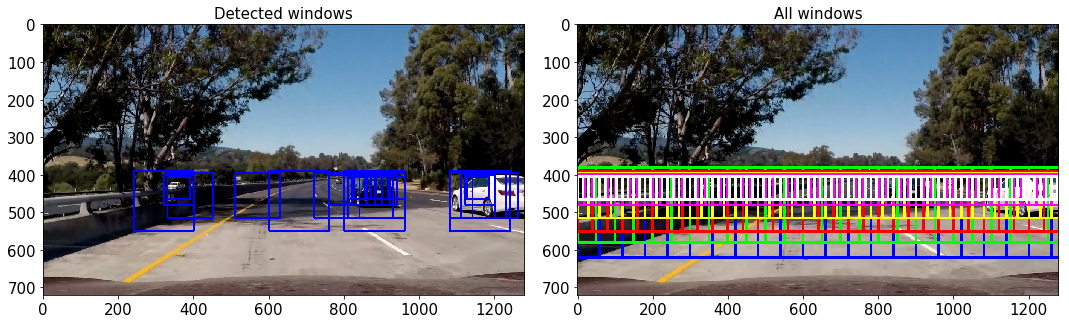

1.23 Seconds to search windows ...
(6,)


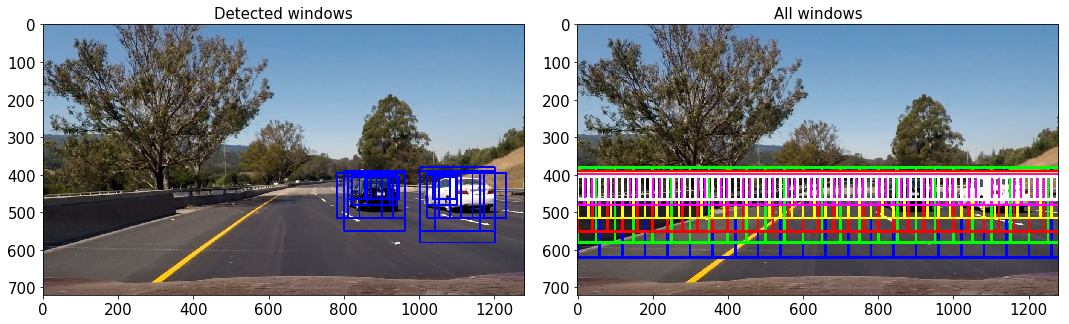

In [46]:
for file in images:
    image = mpimg.imread(file)
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=3)                    

    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,0)
        if ind==4: color= (1,0,1)
        if ind==5: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
      
    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))
    f.tight_layout()
    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=15)
    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=15)
    plt.show()
    #plt.savefig('images/sliding_windows.png')

## Video Pipeline

In [24]:
# Define a class to receive the characteristics of bounding box detections
class BoundingBoxes:
    def __init__(self,n=10):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
                
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


### Step5: Use method like heatmap of recurring detections to avoid false positive/negative classifications
As we could see there are some false positive windows which identify car image on something which are not cars. I use heatmap for the recurring detection and apply threshold to filter out low recurrence which are more likely false positive. 


1.16 Seconds to search windows ...
1.16 Seconds to search windows ...
1.18 Seconds to search windows ...
1.15 Seconds to search windows ...
1.15 Seconds to search windows ...
1.14 Seconds to search windows ...


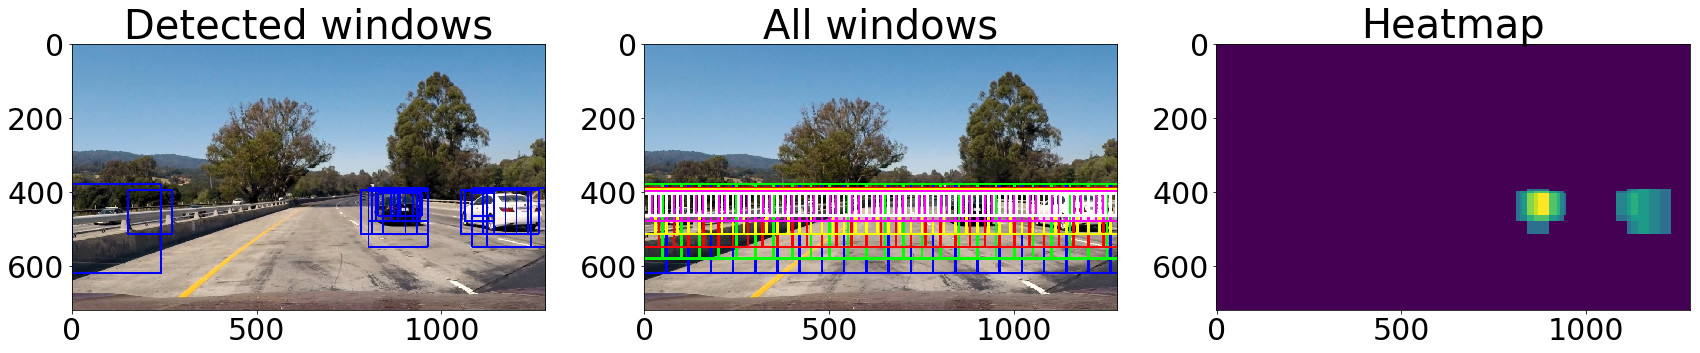

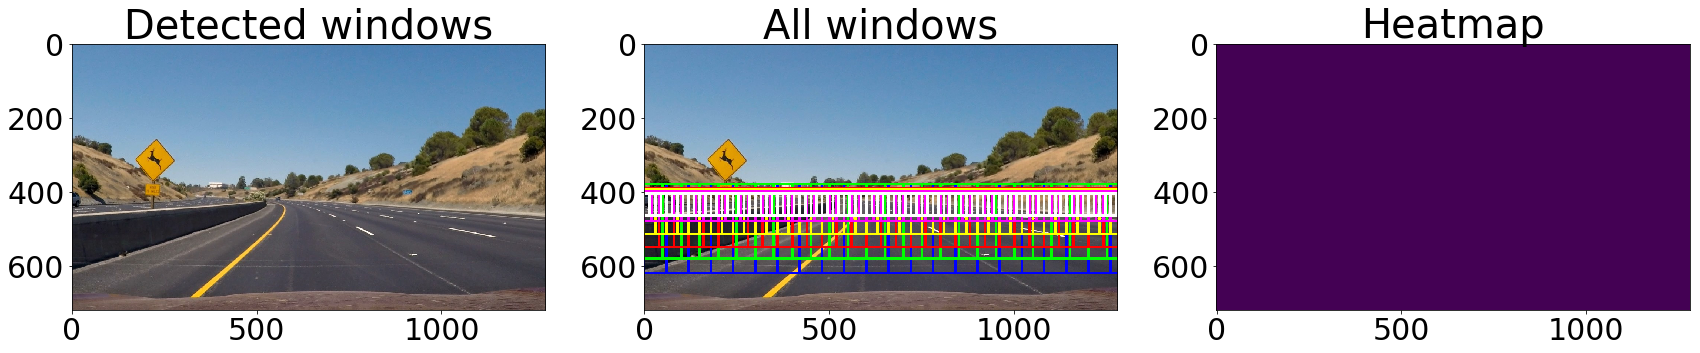

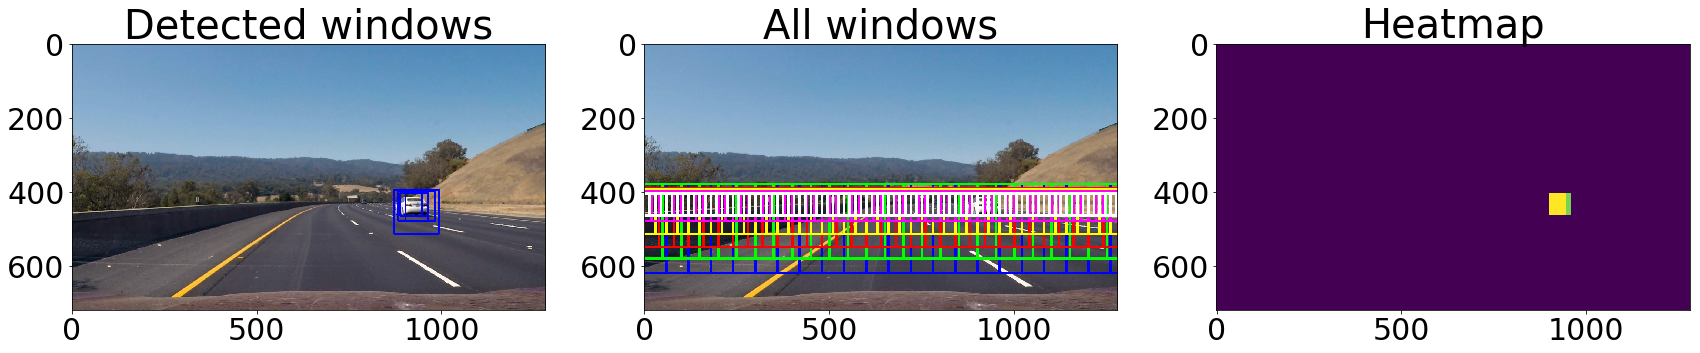

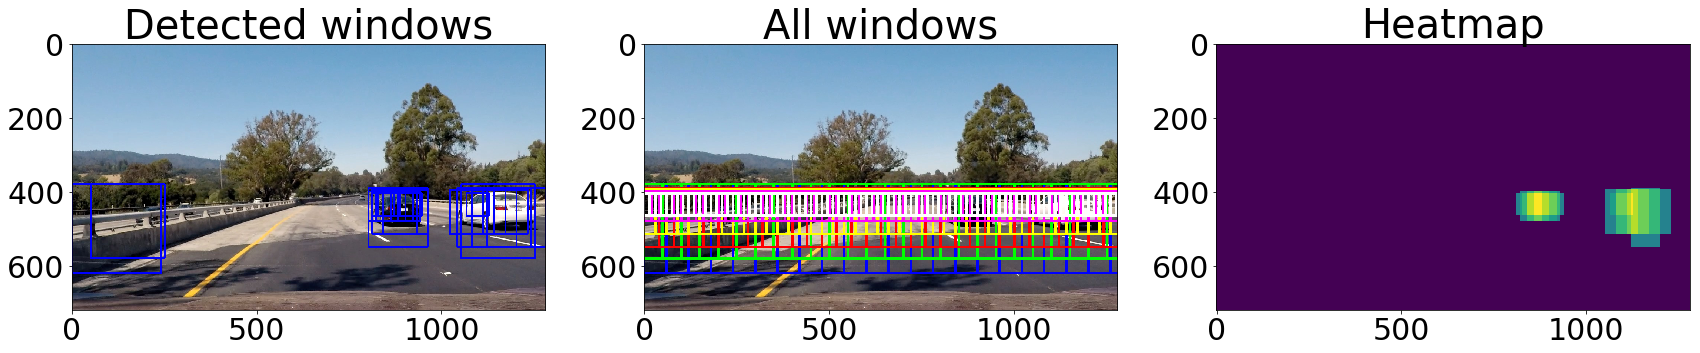

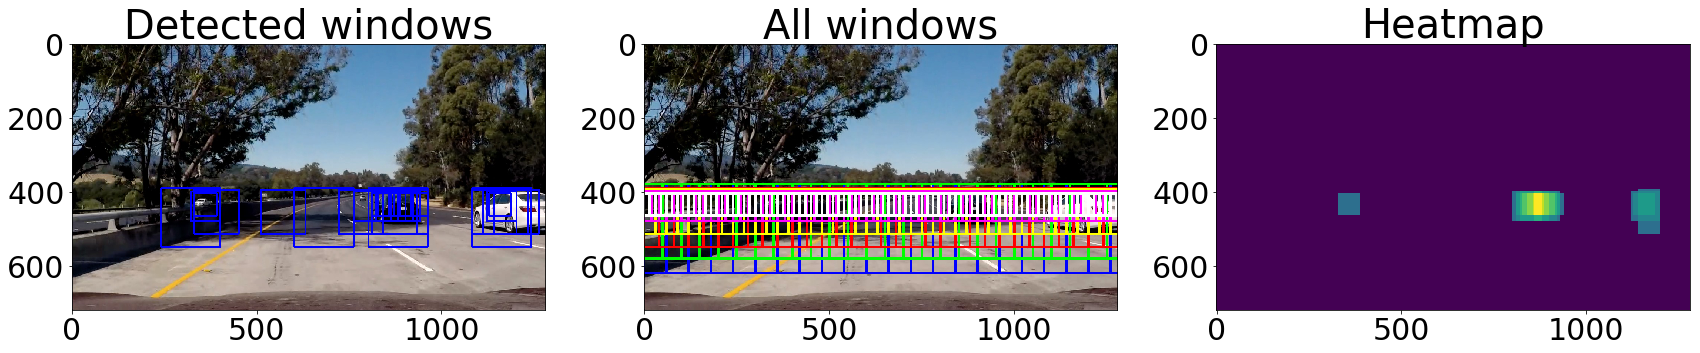

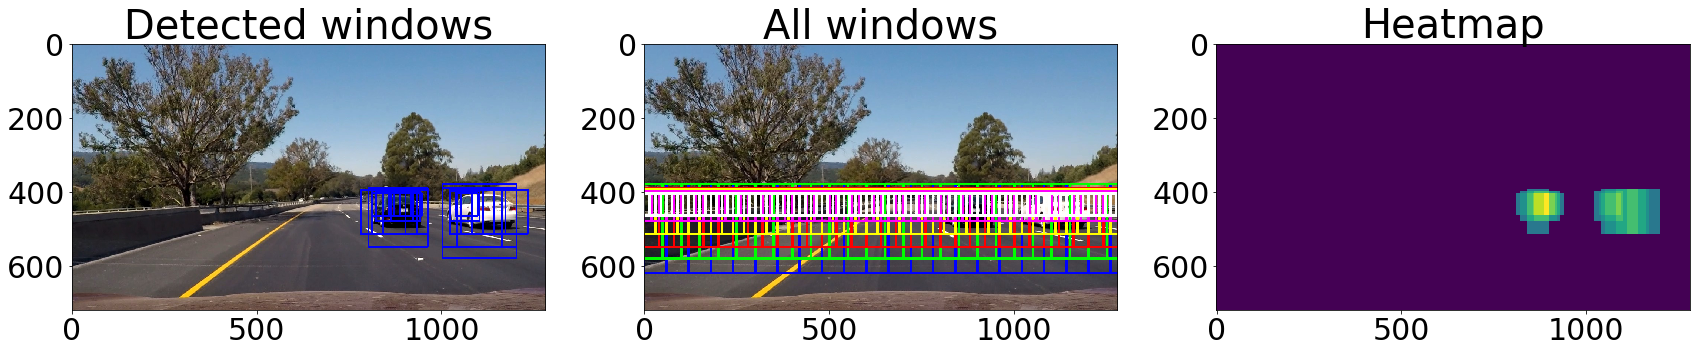

In [25]:
images = sorted(glob.glob('./test_images/*.jpg'))
boxes = BoundingBoxes(n=1)# hot windows of pevios frames storage, but since test images are individually selected, so it is one here

for file in images:
    image = mpimg.imread(file)
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    
    boxes.update(hot_windows)
    
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,0)
        if ind==4: color= (1,0,1)
        if ind==5: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    # Read in the last image shown above 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,3)
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    
    ax3.imshow(heatmap)
    ax3.set_title('Heatmap', fontsize=40)

plt.show()

There are  2 cars found


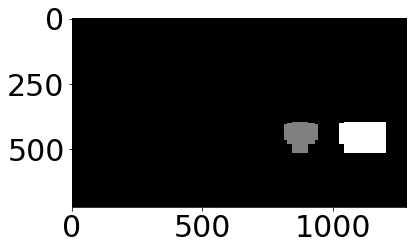

In [26]:
labels = label(heatmap)
print('There are ', labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

In [54]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Below we could see using Heatmap with threshold, we could effectively reduce false positive. 

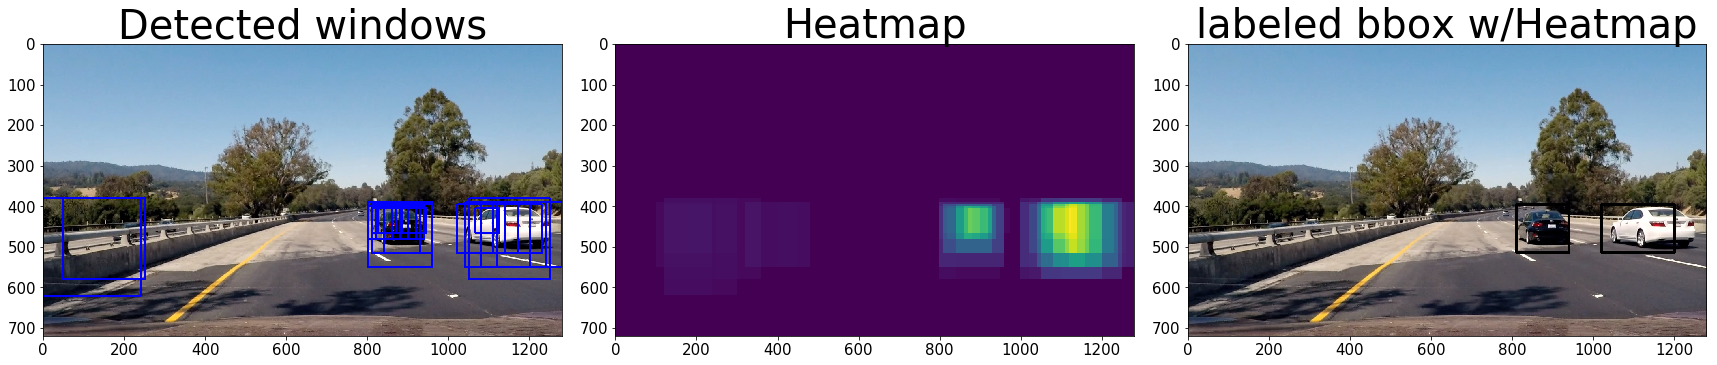

In [56]:
image = mpimg.imread(images[3])
image = image.astype(np.float32)/255
hot_windows,all_windows = search_all_scales(image)
        
#print(np.array(all_windows).shape)
window_img = draw_boxes(image, hot_windows, color=(0, 0, 1), thick=4)                    

heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, boxes.allboxes)
heatmap  = apply_threshold(heatmap,3)
    
plt.figure()    
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(window_img)
ax1.set_title('Detected windows', fontsize=40)
    
ax2.imshow(heatmap)
ax2.set_title('Heatmap', fontsize=40)

draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
ax3.imshow(draw_img)
ax3.set_title('labeled bbox w/Heatmap', fontsize=40)

plt.show()

### Step6: Build video pipeline to process streaming videos with bounding box to detect and track vehicles. Later I apply Advanced Lane Finding with vehicle detection and tracking together. 

In [49]:
boxes = BoundingBoxes(n=30)
def process_image(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,15)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    return window_image


#### Test video

In [50]:
out_dir='./output_images/'
inpfile='test_video.mp4'
outfile=out_dir+'test_processed_r3_MZ_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/test_processed_r3_MZ_test_video.mp4
[MoviePy] Writing video ./output_images/test_processed_r3_MZ_test_video.mp4


 97%|█████████▋| 38/39 [00:48<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_processed_r3_MZ_test_video.mp4 

CPU times: user 47.5 s, sys: 442 ms, total: 48 s
Wall time: 48.8 s


#### Project_video

In [57]:
del boxes
boxes = BoundingBoxes(n=30)
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_r3_MZ_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_r3_MZ_project_video.mp4
[MoviePy] Writing video ./output_images/processed_r3_MZ_project_video.mp4


100%|█████████▉| 1260/1261 [25:07<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_r3_MZ_project_video.mp4 

CPU times: user 24min 48s, sys: 13.5 s, total: 25min 1s
Wall time: 25min 8s


### Below I apply the Advanced Lane Finding onto this Vehicle Detection and Tracking

In [66]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
get_ipython().magic('matplotlib inline')

class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 15./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/900 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals)*ym_per_pix + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
# Next I create a function `process_vid()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.
# 
# The video processing pipeline is very similar to the `fill_lanes()` function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.
# 
# The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.
# Video Processing Pipeline
def process_vid(image):
    # Left = Line()
    # Right = Line()
    
    data_file = 'CameraData.p'
    with open(data_file, mode='rb') as f:
        data = pickle.load(f)
        
    objpoints = data['objpoints']
    imgpoints = data['imgpoints']
    
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    r_channel = warped[:,:,2]
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the r channel
    r_thresh_min = 225
    r_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(r_binary == 1) |(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/900) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [67]:
# from Advanced_Lane_Finding_functions import *

boxes = BoundingBoxes(n=30)

def process_image_wLane(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,15)
    labels = label(heatmap)
    
    draw_image2 = process_vid(draw_image)
    window_image = draw_labeled_bboxes(draw_image2, labels)

    #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    return window_image

In [68]:
Left = Line()
Right = Line()
out_dir='./output_images/'
inpfile='test_video.mp4'
outfile=out_dir+'test_processed_wLane_r4_'+inpfile
clip1 = VideoFileClip(inpfile)
out_clip1 = clip1.fl_image(process_image_wLane) 
%time out_clip1.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/test_processed_wLane_r4_test_video.mp4
[MoviePy] Writing video ./output_images/test_processed_wLane_r4_test_video.mp4


 97%|█████████▋| 38/39 [01:14<00:01,  1.90s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_processed_wLane_r4_test_video.mp4 

CPU times: user 1min 16s, sys: 897 ms, total: 1min 17s
Wall time: 1min 14s


In [69]:
del boxes
boxes = BoundingBoxes(n=30)
Left = Line()
Right = Line()
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_wLane_r4_'+inpfile
clip1 = VideoFileClip(inpfile)
out_clip1 = clip1.fl_image(process_image_wLane) 
%time out_clip1.write_videofile(outfile, audio=False)


[MoviePy] >>>> Building video ./output_images/processed_wLane_r4_project_video.mp4
[MoviePy] Writing video ./output_images/processed_wLane_r4_project_video.mp4


100%|█████████▉| 1260/1261 [42:53<00:02,  2.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_wLane_r4_project_video.mp4 

CPU times: user 44min 7s, sys: 33.5 s, total: 44min 41s
Wall time: 42min 54s
